<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу;
2. Проанализировать данные;
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных;
4. Проверить данные на тестовой выборке и сделать выводы


* `'num_orders'` - количество заказов;

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
def my_info(x, y):  # аргумент x примет значение сохраненного датасета в переменной;
                    # аргумент y примет описательный характер датасета, по которому будет описываться информация
    print(y)
    display(x.head())
    print(f'Размер {y}: {x.shape}')
    print()
    print(f'Информация о {y}:')
    print()
    display(x.info())
    display(x.describe())
    print(f'Кол-во пропущенных значений в {y}:') 
    display(x.isna().sum())
    print()
    print(f'Кол-во дубликатов в {y}: {x.duplicated().sum()}')
    
    
my_info(data, 'data')

data


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Размер data: (26496, 1)

Информация о data:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Кол-во пропущенных значений в data:


num_orders    0
dtype: int64


Кол-во дубликатов в data: 26415


Для дальнейшей работы с временным рядом, **нужно ипсравить** некорректный **тип данных** в колонке `datetime` с строкового на datetime.

Есть несколько вариантов:
* **1)** применить `pd.to_datetime()` к нужной колонке;
* **2)** вписать при чтении файла аргумент `parse_dates=[index]` столбца

Использовали более удобный способ **(2)**. 

Также применили индексацию к этому столбцу (`datetime`), путем внедрения аргумента `index_col=[index]` (второй способ **set_index() к столбцу**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Привели к нужному типу.**

* Теперь отсортируем индексы во возрастанию (самой даты);
* Проверим, является ли индекс **монотонным** , то есть в хронологичксом ли порядке находятся даты/время;
* И **произведем ресемплирование по 1 часу**

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.index.is_monotonic # если True, то является 

True

In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum() # выбираем длину в 1 час, и агрегируем суммы
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


* Рассмотрели данные;
* Чтобы корректно работать с датой и временем, изменили тип данных соответствующего столбца с `object` на `datetime64`;
* Произвели **ресемплирование** данных по **1 часу**


## Анализ

Смотрим на график и вычисляем, за какой период даны данные

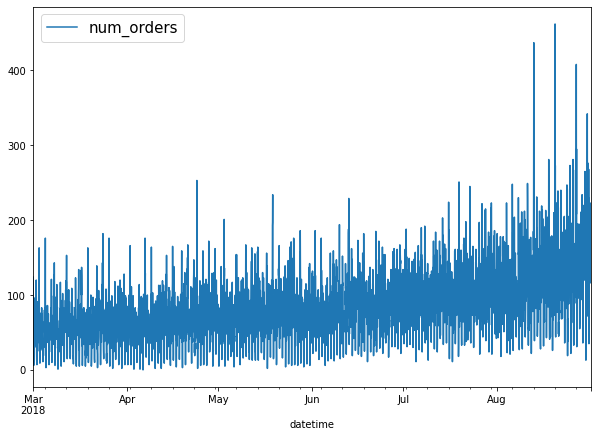

In [8]:
data.plot(figsize=(10, 7), legend=True)
plt.legend(fontsize=15);

In [9]:
print(f'Данные даны за период с {data.index.min()} по {data.index.max()}')

Данные даны за период с 2018-03-01 00:00:00 по 2018-08-31 23:00:00


По графику и индексам данных наблюдаем, что анализ **проводится** с `Марта (03) 2018` года по `Август (08) 201`8, то есть **6 месяцев**. Но по нему ничего не понятно

**Разложим временной ряд на `тренд`, `сезонность` и `остаток` при помощи библиотеки `statsmodels` с функцией `seasonal_decompose()`**

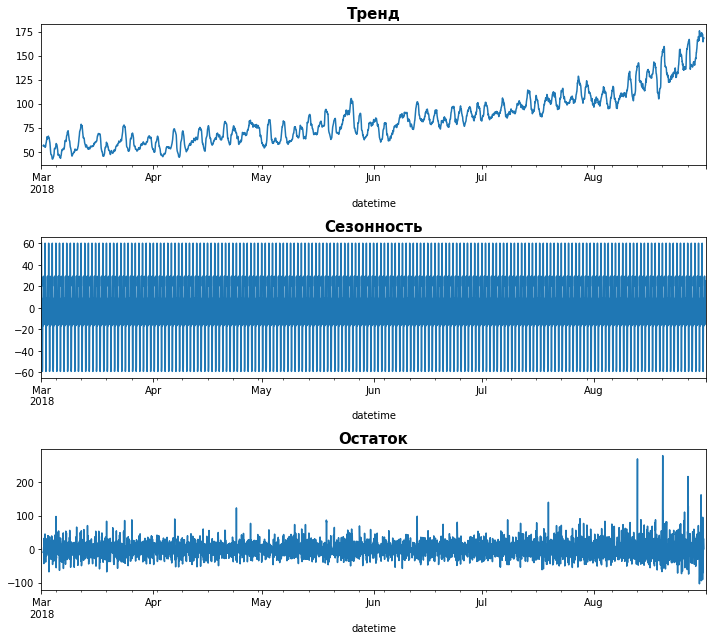

In [10]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) # Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca(), то есть 
                                    # получить текущие оси
plt.title('Тренд', fontsize=15, fontweight='bold')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность', fontsize=15, fontweight='bold')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток', fontsize=15, fontweight='bold')
plt.tight_layout()

**Временной ряд** на графике **Тренда нестационарный**, так как у него **меняется среднее значение**. Тренды и сезонность зависят от масштаба данных. **Нельзя** увидеть **закономерности**, повторяющиеся каждое лето/весна, если есть **данные** только **за полгода**, поэтому сезонность (с периодом меньше месяца), **нужно посмотреть детальнее**.

`Для это рассмотрим сезонность ближе (по нескольким дням)`

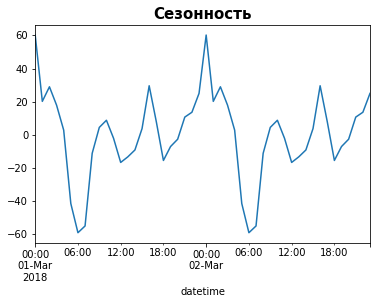

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Сезонность', fontsize=15, fontweight='bold');

Наблюдаем, что активность заказов **очень низка** рано утром в **6 a.m.**. **Подымается** до примерно **11 a.m.** (диапазон, чтобы добратсья до работы, например), и **самый пик** замечаем **к 00:00** (когда общественный транспорт менее удобен по таймингу)

* Рассмотрим теперь ресемплирование по дням, то есть чуть шире

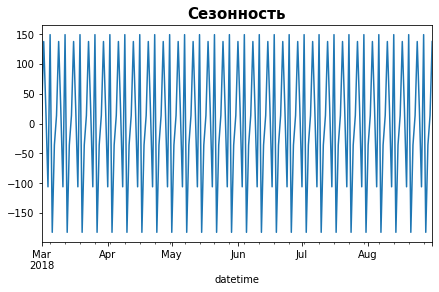

In [12]:
deacompose_d = seasonal_decompose(data.resample('1D').sum())
deacompose_d.seasonal.plot(figsize=(7, 4), ax=plt.gca())
plt.title('Сезонность', fontsize=15, fontweight='bold');

Наблюдаем тенденцию **понижения активности где-то около выходных**. Возможно, это связано с тем, что большинство людей предпочитают остаться дома, либо поехать на ином транспорте (личном/общественном) куда-нибудь отдохнуть (центр/за город)

**Создадим признаки для дальнейшего обучения модели**
* Введем функцию `make_features()`, которая создаст такие признаки:
  * **календарные**: они выносят временные рамки `(года, месяца, дни, дни недели, часы)` в отдельные колонки;
  * **отстающие значения**: предыдущие значения временного ряда подскажут, будет ли `расти или уменьшяаться` функция **x(t)**, где t - время;
  * **скользящее среднее**: эти значения как признак зададут `общий тренд временного ряда`
  
В функции `make_features()` будет 3 аргумента: **data** `(сами данные)`, **max_lag** `(максимальный рзамер отставания)` и **rolling_mean_size** `(задает ширину окна)`

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_lag + 1): # чтобы не вышел за рендж
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 20, 5)
my_info(data, 'data')

data


,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Размер data: (4416, 26)

Информация о data:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   year          4416 non-null   int64  
 2   month         4416 non-null   int64  
 3   day           4416 non-null   int64  
 4   dayofweek     4416 non-null   int64  
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-nu

None

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
count,4416.000000,4416.0,4416.000000,4416.000000,4416.000000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,...,4404.000000,4403.000000,4402.00000,4401.000000,4400.000000,4399.000000,4398.000000,4397.000000,4396.000000,4411.000000
mean,84.422781,2018.0,5.505435,15.836957,3.005435,84.395470,84.364069,84.347156,84.331369,84.319655,...,84.187557,84.168749,84.14448,84.117473,84.095227,84.103887,84.115052,84.116443,84.074613,84.346316
std,45.023853,0.0,1.713306,8.855229,1.990684,44.992356,44.949043,44.940088,44.932942,44.931299,...,44.819924,44.807630,44.78377,44.752994,44.733738,44.735135,44.734091,44.739084,44.658098,34.297233
min,0.000000,2018.0,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
25%,54.000000,2018.0,4.000000,8.000000,1.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.00000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,61.600000
50%,78.000000,2018.0,5.500000,16.000000,3.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.00000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.800000
75%,107.000000,2018.0,7.000000,23.250000,5.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.00000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,102.600000
max,462.000000,2018.0,8.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,286.200000


Кол-во пропущенных значений в data:


num_orders       0
year             0
month            0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
rolling_mean     5
dtype: int64


Кол-во дубликатов в data: 0


**Добавили признаки в датафрейм.** Вывели функцией информацию о новом датасете. Подмечаем логичное появление пропусков, так как произошли сдвиги командой `shift()`. В дальнейшем мы избавимся от них. 

Теперь для обучения нужно их разделить. `Разделим датасет на выборки (обучающую и тестовую) и определим признаки`

* Методом `train_test_split()` поделим данные на выборки, поставим чтобы он их не мешал аргументом `shuffle=False`, так как данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным, то есть чтобы модель не обучалась значениями из будущего ставим этот аргумент


* В поставленной задаче сказано, что `нужно сделать тестовую выборку` размером **10%** `от исходных данных`. Ставим деление аргументом `test_size=0.1`


* Далее введем функцию **sample(x)**, где **x** - это выборка (`обучающая или тестовая`), которая разделит признаки и целевой по выборкам

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna() # избавляемся от пропусков

def sample(x):
    
    features = x.drop('num_orders', axis=1)
    target = x['num_orders']
    
    print(f'Размер выборки: {features.shape}') # проверяем корректное деление

    return features, target

features_train, target_train = sample(train)
features_test, target_test = sample(test)
print()
print(f'Обучающая: с {train.index.min()} по {train.index.max()}') # убедиться в корректности деления
print(f'Тестовая: с {test.index.min()} по {test.index.max()}')
#my_info(features_test, 'test')

Размер выборки: (3954, 25)
Размер выборки: (442, 25)

Обучающая: с 2018-03-01 20:00:00 по 2018-08-13 13:00:00
Тестовая: с 2018-08-13 14:00:00 по 2018-08-31 23:00:00


## Обучение

Теперь приступаем к обучению моделей

Параметры будем подбирать с помощью **GridSearchCV**

В задаче сказано, что для `оценки качества моделей применятся метрика` **RMSE**. Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**.

* Введем функцию, которая будет расчитывать метрику **RMSE**

In [15]:
def rmse(target, predict):
    mse = mean_squared_error(target, predict)
    rmse = np.sqrt(mse)
    
    return rmse

* Создаем функцию для рассчитывания параметров и лучшего значения для **rmse**. Считать будем при помощи **`GridSearchCV()`**. Эта техника обучает модель с заданными нами в перечни параметрами, из которых выберет лучшие для метрики **rmse**, используя кросс валидацию (после проведем финальную проверку на тестовой). 

* С помощью параметра `make_scorer()` внесем расчетную метрику - нашу **функцию rmse**, а также параметр `greater_is_better=False` (принято ставить `greater_is_better=False` для метрик, которые являются лоссами). Так как на выходе получается отрицательное число, приводим его в абсолютное с помощью `abs()`, чтобы не посчитал иначе при использовании этого параметра.

* Лучшее значение **rmse** выводим с помощью атрибута `.best_score_`, а лучшие параметры с помощью `.best_params_`

На вход функция принимает **5 аргументов**: `сама модель`, `перечень параметров`, `признаки`, `целевой признак` и `название модели`. С ее помощью мы найдем лучшее значение **RMSE** с лучшими гиперпараметрами. Затем проверим модели на тестовой выборке и сравним значение **RMSE**

**Важно**

При работе с временными рядами нельзя использовать стандартную `кросс-валидацию`, так как в определенный момент тренировочная выборка окажется позже валидационной. Для решения этой проблемы стоит использовать **`TimeSeriesSplit`**. Объект этого типа нужно передать в параметр **`cv`** в метод основанный на `кросс-валидации`.

In [16]:
def best_model(model, params, features, target, model_name):
    
    tss = TimeSeriesSplit(n_splits=5)
    cvs = GridSearchCV(model, params, scoring=make_scorer(rmse, greater_is_better=False), cv=tss)
    
    cvs.fit(features, target)
    
    print(f'Лучшие параметры модели {model_name}: {cvs.best_params_}')
    print()
    print(f'Лучший RMSE модели {model_name}: {round(abs(cvs.best_score_), 4)}')
    print()

* Первой будет модель **Линейной Регрессии**. Сначала выявим гиперпараметр при лучшем значении **RMSE** посчитанным **GridSearch**

In [17]:
%%time

model_lr = LinearRegression()

params_lr = {'normalize': [True, False]}

best_model(model_lr, params_lr, features_train, target_train, 'Линейной Регрессии')

Лучшие параметры модели Линейной Регрессии: {'normalize': False}

Лучший RMSE модели Линейной Регрессии: 31.275

CPU times: user 452 ms, sys: 1.27 s, total: 1.72 s
Wall time: 1.71 s


Теперь обучим модель с этмм гиперпараметром и посмотрим значение **RMSE**. При анализе модели, мы будем предсказывать на обучающей выборке и соответственно считать **RMSE** тоже на ней. Финальное тестирование проведем на тестовой выборке.

In [18]:
%%time

model_lr = LinearRegression(normalize=True)
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_train)
rmse_lr = rmse(target_train, predict_lr)
print(f'RMSE модели Линейной Регрессии: {round(rmse_lr, 4)}')

RMSE модели Линейной Регрессии: 29.2486
CPU times: user 48.6 ms, sys: 142 ms, total: 190 ms
Wall time: 199 ms


* Используем модели градиентного бустинга. Начнем с **CatBoostRegressor**

In [19]:
%%time


model_cbr = CatBoostRegressor(loss_function='RMSE', verbose=50, random_state=12345)

params_cbr = {'iterations': range(80, 151, 35), 'max_depth': range(2, 7, 2)}

best_model(model_cbr, params_cbr, features_train, target_train, 'CatBoostRegressor')

Learning rate set to 0.29878
0:	learn: 27.5069196	total: 46.6ms	remaining: 3.68s
50:	learn: 16.6533710	total: 69.2ms	remaining: 39.4ms
79:	learn: 14.9442637	total: 87.8ms	remaining: 0us
Learning rate set to 0.33336
0:	learn: 27.8797220	total: 791us	remaining: 62.5ms
50:	learn: 18.8985450	total: 27.2ms	remaining: 15.5ms
79:	learn: 17.4291181	total: 43.8ms	remaining: 0us
Learning rate set to 0.355416
0:	learn: 29.4800057	total: 952us	remaining: 75.2ms
50:	learn: 20.1275522	total: 34.9ms	remaining: 19.9ms
79:	learn: 18.7022004	total: 54.3ms	remaining: 0us
Learning rate set to 0.371943
0:	learn: 30.8913341	total: 1.19ms	remaining: 93.8ms
50:	learn: 21.5039055	total: 39.7ms	remaining: 22.6ms
79:	learn: 20.0135094	total: 63.4ms	remaining: 0us
Learning rate set to 0.385291
0:	learn: 32.2203921	total: 1.17ms	remaining: 92.2ms
50:	learn: 22.8158985	total: 44.5ms	remaining: 25.3ms
79:	learn: 21.6142235	total: 71ms	remaining: 0us
Learning rate set to 0.29878
0:	learn: 27.3727831	total: 1.73ms	rem

Подобрали гиперпараметры. Теперь обучим и посмотрим на значение **RMSE**

In [20]:
%%time

model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=150, max_depth=4, random_state=12345)
model_cbr.fit(features_train, target_train, verbose=50)
predict_cbr = model_cbr.predict(features_train)
rmse_cbr = rmse(target_train, predict_cbr)
print(f'RMSE модели CatBoostRegressor: {round(rmse_cbr, 4)}')

Learning rate set to 0.237875
0:	learn: 36.1407696	total: 2.54ms	remaining: 379ms
50:	learn: 23.2073780	total: 104ms	remaining: 202ms
100:	learn: 20.3277348	total: 207ms	remaining: 101ms
149:	learn: 18.5991703	total: 323ms	remaining: 0us
RMSE модели CatBoostRegressor: 18.5992
CPU times: user 339 ms, sys: 26.7 ms, total: 365 ms
Wall time: 926 ms


* Рассмотрим модель **LightGBM**

In [21]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.1) 

params_lgbm = {'max_depth': range(7, 12, 2), 'n_estimators': [110, 160, 210]}

best_model(model_lgbm, params_lgbm, features_train, target_train, 'LGMB')

Лучшие параметры модели LGMB: {'max_depth': 9, 'n_estimators': 110}

Лучший RMSE модели LGMB: 27.897

CPU times: user 54.1 s, sys: 146 ms, total: 54.3 s
Wall time: 54.7 s


Обучим на этих гиперпараметрах модель **LGBM** и посмотрим на значение метрики качества **RMSE**

In [22]:
%%time

model_lgbm = LGBMRegressor(max_depth=9, n_estimators=110, learning_rate=0.1)
model_lgbm.fit(features_train, target_train)
predict_lgbm = model_lgbm.predict(features_train)
rmse_lgbm = rmse(target_train, predict_lgbm)
print(f'RMSE модели LGBMRegressor: {round(rmse_lgbm, 4)}')

RMSE модели LGBMRegressor: 13.1523
CPU times: user 1.22 s, sys: 10.2 ms, total: 1.23 s
Wall time: 1.29 s


Нашли гиперпараметры и выявили значения метрики качества **RMSE** на обучающей выборке для трех моделей: **LGBM**, **CatBoostRegressor** и **LinearRegression**. Теперь проверим данные на тестовой выборке


## Тестирование

* `Снова обучим модели и предскажем на тестовой выборке`

In [23]:
%%time

model_lr = LinearRegression(normalize=True)
model_lr.fit(features_train, target_train)
predict_lr_final = model_lr.predict(features_test)
rmse_lr_final = rmse(target_test, predict_lr_final)
print(f'Финальное значение RMSE модели Линейной Регрессии: {round(rmse_lr_final, 4)}')

Финальное значение RMSE модели Линейной Регрессии: 55.2399
CPU times: user 6.12 ms, sys: 21.5 ms, total: 27.6 ms
Wall time: 7.81 ms


In [24]:
%%time

model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=150, max_depth=4, random_state=12345)
model_cbr.fit(features_train, target_train, verbose=50)
predict_cbr_final = model_cbr.predict(features_test)
rmse_cbr_final = rmse(target_test, predict_cbr_final)
print(f'Финальное значение RMSE модели CatBoostRegressor: {round(rmse_cbr_final, 4)}')

Learning rate set to 0.237875
0:	learn: 36.1407696	total: 2.41ms	remaining: 359ms
50:	learn: 23.2073780	total: 97.4ms	remaining: 189ms
100:	learn: 20.3277348	total: 193ms	remaining: 93.5ms
149:	learn: 18.5991703	total: 285ms	remaining: 0us
Финальное значение RMSE модели CatBoostRegressor: 46.8336
CPU times: user 315 ms, sys: 8.33 ms, total: 323 ms
Wall time: 953 ms


In [25]:
%%time

model_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=9, n_estimators=110)
model_lgbm.fit(features_train, target_train)
predict_lgbm_final = model_lgbm.predict(features_test)
rmse_lgbm_final = rmse(target_test, predict_lgbm_final)
print(f'Финальное значение RMSE модели LGBMRegressor: {round(rmse_lgbm_final, 4)}')

Финальное значение RMSE модели LGBMRegressor: 47.3001
CPU times: user 968 ms, sys: 1.26 ms, total: 970 ms
Wall time: 851 ms


**Для визуального восприятия выведем все значения метрики `RMSE` (финальной и на обучающей) и время обучения с предсказанием каждой модели в единый датафрейм**

In [29]:
table = pd.DataFrame({'модель': ['LinearRegressor', 'CatBoostRegressor', 'LGBMRegressor'], 
                      '~ время обучения и предсказания (сек.)': [0.01, 0.95, 0.85], 
                      'RMSE на обучающей': [round(rmse_lr, 4), round(rmse_cbr, 4), round(rmse_lgbm, 4)], 
                      'RMSE финальный': [round(rmse_lr_final, 4), round(rmse_cbr_final, 4), 
                                         round(rmse_lgbm_final, 4)]})

table = table.set_index('модель')
table

,~ время обучения и предсказания (сек.),RMSE на обучающей,RMSE финальный
модель,,,
LinearRegressor,0.01,29.2486,55.2399
CatBoostRegressor,0.95,18.5992,46.8336
LGBMRegressor,0.85,13.1523,47.3001


Для окончательного вывода стоит проверить на адекватность выявленные модели, а **также подходит ли по критерию начального значения `RMSE`**. 

* Заполняем единицами размер целевого тестовой выборки и умножаем на среднее значение целевого обучающей выборки, затем кастомной функцией **rmse** рассчитываем константу этой метрики для данного временного ряда

**Вводим константу** и **константное** значение **RMSE**:

In [30]:
RMSE_CONST = 48
predict_const = np.ones(target_test.shape) * target_train.mean()
const_rmse = rmse(target_test, predict_const)
print(const_rmse)
print()

if rmse_lgbm_final < const_rmse > rmse_cbr_final and rmse_cbr_final < RMSE_CONST > rmse_lgbm_final:
    print('Выявленная модель прошла тест на адекватность и подходит по установленным критериям')
else:
    print('Что-то пошло не так')

84.6528030070785

Выявленная модель прошла тест на адекватность и подходит по установленным критериям


В результате анализа подошли по критерию две модели: **CatBoostRegressor** и **LGMBRegressor**

## Вывод

* Данные были загружены и просмотрены введенной функцией;
* Исправили тип данных с **str** строкового на **datetime64** при помощи аргумента `parse_dates=[index]`, чтобы было в дальнейшем удобнее работать с временным рядом;
* При помощи аргумента `index_col=[index]` установили индекс таблицы равным столбцу **datetime**;
* Произвели **ресемплирование** по **1 часу**;
* Разложили временной ряд на `тренд`, `сезонность` и `остаток` при помощи библиотеки `statsmodels` с функцией `seasonal_decompose()`;
* Проанализировали активность заказов такси по нему;
* Были добавлены новые признаки для обучения моделей;
* Данные были разделены в соответствии условий (**10% тестовой выборки** от исходных данных);
* Была добавлена функция **rmse**, как расчет метрики **RMSE**;
* Также была введена функция **best_model**, в которую была передана кастомная функция **rmse** как `score`. Также благодаря ей были рассчитаны **RMSE** моделей и лучшие гиперпараметры для них при помощи **GridSearchCv**;
* Были приведены **три модели** в качестве прогнозирования кол-во заказов такси на следующий час: `LinearRegression`, `CatBoostRegressor` и `LGMBRegressor`;
* В результате анализа и финальной проверки на тестовой выборке, выявили модели для компании «Чётенькое такси»: 
  
  * **CatBoostRegressor `(~ 46.8)`** и **LGMBRegressor `(~ 47.3)`**
  
**Таблица для визуализации результатов**

In [31]:
table

,~ время обучения и предсказания (сек.),RMSE на обучающей,RMSE финальный
модель,,,
LinearRegressor,0.01,29.2486,55.2399
CatBoostRegressor,0.95,18.5992,46.8336
LGBMRegressor,0.85,13.1523,47.3001
